In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
print('Libraries imported.')

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [67]:
#Download list of area code from https://www.downloadexcelfiles.com/us_en/download-list-us-zip-codes-massachusetts-state#.YQLcrY5Kg2w and import into Notebook

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_84a236263e4d4fff9d7ea966df851050 = 'https://s3.us.cloud-object-storage.appdomain.cloud'
else:
    endpoint_84a236263e4d4fff9d7ea966df851050 = 'https://s3.private.us.cloud-object-storage.appdomain.cloud'

client_84a236263e4d4fff9d7ea966df851050 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='8rAMGZZi0nnYOg5tM5QR5j-e78MKR1Tv6BA2e0i5F5pu',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_84a236263e4d4fff9d7ea966df851050)

body = client_84a236263e4d4fff9d7ea966df851050.get_object(Bucket='courseracapstone-donotdelete-pr-vs1twujrsxlmyw',Key='ma-zip.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

MA_data = pd.read_csv(body)
MA_data.drop(['State', 'Zipcode name'], axis=1, inplace=True)
MA_data.rename(columns={'County Name':'County','City':'Neighborhood'}, inplace=True)
MA_data.head()

,zip,Neighborhood,County
0,2351,ABINGTON,PLYMOUTH
1,2018,ACCORD,PLYMOUTH
2,1720,ACTON,MIDDLESEX
3,2743,ACUSHNET,BRISTOL
4,1220,ADAMS,BERKSHIRE


In [68]:
#Get latitude, Longitude, Estimated Population from https://data.healthcare.gov/resource/52wv-g36k.json
body = client_84a236263e4d4fff9d7ea966df851050.get_object(Bucket='courseracapstone-donotdelete-pr-vs1twujrsxlmyw',Key='Geocodes_USA_with_Counties.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

geo_df= pd.read_csv(body)
geo_df.head()

,zip,primary_city,state,latitude,longitude,county,type,world_region,country,decommissioned,estimated_population,notes
0,501,Holtsville,NY,40.81,-73.04,Suffolk,UNIQUE,NaN,US,0,384,NaN
1,544,Holtsville,NY,40.81,-73.04,Suffolk,UNIQUE,NaN,US,0,0,NaN
2,601,Adjuntas,PR,18.16,-66.72,Adjuntas,STANDARD,NaN,US,0,0,NaN
3,602,Aguada,PR,18.38,-67.18,NaN,STANDARD,NaN,US,0,0,NaN
4,603,Aguadilla,PR,18.43,-67.15,Aguadilla,STANDARD,NaN,US,0,0,NaN


In [69]:
#Create MA dataset
ma_zip=geo_df[geo_df.state == 'MA']
ma_zip=ma_zip[['zip', 'latitude', 'longitude']]
ma_zip.rename(columns={'latitude':'Latitude','longitude':'Longitude'}, inplace=True)
ma_zip["zip"] = ma_zip["zip"].astype(int).astype(str)
ma_zip.head()

,zip,Latitude,Longitude
194,1001,42.06,-72.61
195,1002,42.37,-72.52
196,1003,42.37,-72.52
197,1004,42.37,-72.52
198,1005,42.42,-72.10


In [70]:
MA_df = pd.merge(MA_data, ma_zip, on="zip")
MA_df.drop(['zip'], axis=1, inplace=True)
MA_df = MA_df.drop_duplicates()
MA_df.head(5)

,Neighborhood,County,Latitude,Longitude
0,ABINGTON,PLYMOUTH,42.11,-70.95
1,ACCORD,PLYMOUTH,42.17,-70.88
2,ACTON,MIDDLESEX,42.48,-71.46
3,ACUSHNET,BRISTOL,41.68,-70.90
4,ADAMS,BERKSHIRE,42.62,-73.11


In [8]:
print('The dataframe has {} counties and {} neighborhoods.'.format(
        len(MA_df['County'].unique()),
        MA_df.shape[0]
    )
)

The dataframe has 14 counties and 512 neighborhoods.


In [22]:
MA_df.dtypes

Neighborhood     object
County           object
Latitude        float64
Longitude       float64
dtype: object

In [71]:
address = 'Massachusetts'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Massachusetts= folium.Map(location=[latitude, longitude], zoom_start=10)

for row in MA_df.iterrows():
    lat = row[1]['Latitude']
    lng = row[1]['Longitude']
    label = row[1]['Neighborhood']

# for lat, lng, label in zip(boston_data['Latitude'], boston_data['Longitude'], boston_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Massachusetts)  
    
map_Massachusetts

In [72]:
# create map of Boston Area using latitude and longitude values
boston_data = MA_df[MA_df['County'] == 'SUFFOLK'].reset_index(drop=True)
boston_data = boston_data.drop_duplicates()
boston_data.head(10)

,Neighborhood,County,Latitude,Longitude
0,ALLSTON,SUFFOLK,42.35,-71.13
1,BOSTON,SUFFOLK,42.35,-71.06
2,BRIGHTON,SUFFOLK,42.35,-71.15
3,CHARLESTOWN,SUFFOLK,42.38,-71.06
4,CHELSEA,SUFFOLK,42.39,-71.03
5,DORCHESTER,SUFFOLK,42.35,-71.06
6,DORCHESTER CENTER,SUFFOLK,42.35,-71.06
7,EAST BOSTON,SUFFOLK,42.35,-71.06
8,HYDE PARK,SUFFOLK,42.26,-71.11
9,JAMAICA PLAIN,SUFFOLK,42.30,-71.11


In [73]:
address = 'Boston, MA'
geolocator = Nominatim(user_agent="boston_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Boston is 42.3602534, -71.0582912.


In [74]:
#Create Map of Boston Area
map_boston = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
# boston_data['Neighborhood']
for row in boston_data.iterrows():
    lat = row[1]['Latitude']
    lng = row[1]['Longitude']
    label = row[1]['Neighborhood']

# for lat, lng, label in zip(boston_data['Latitude'], boston_data['Longitude'], boston_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)  
    
map_boston

In [75]:
CLIENT_ID = '44HVGZUCVIWDKLIRDFBK0RD5AE1Y104A2HGKYTI4S4UI0X3C'
CLIENT_SECRET = '1YWAC1PR5DKL4IWEAIS4Y5HTM2XPWV1E1JCVI5Y5DAVDIZSJ'

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 44HVGZUCVIWDKLIRDFBK0RD5AE1Y104A2HGKYTI4S4UI0X3C
CLIENT_SECRET:1YWAC1PR5DKL4IWEAIS4Y5HTM2XPWV1E1JCVI5Y5DAVDIZSJ


In [76]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
     #set variables
    radius=3000
    LIMIT=200
    CLIENT_ID = '44HVGZUCVIWDKLIRDFBK0RD5AE1Y104A2HGKYTI4S4UI0X3C'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='1YWAC1PR5DKL4IWEAIS4Y5HTM2XPWV1E1JCVI5Y5DAVDIZSJ' # Foursquare Secret, note there is a daily call quota it
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500, 
            100)
            
        # make the GET request
        #print(requests.get(url).json())
        group_data = requests.get(url).json().get("response").get('groups')
        
        if group_data:
            results = group_data[0].get('items')
        else:
            results=''
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v.get("venue").get("id"),
            v.get('venue').get('name'), 
            v.get('venue').get('location').get('lat'), 
            v.get('venue').get('location').get('lng'),  
            v.get('venue').get('categories')[0].get('name')) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [78]:
boston_venues = getNearbyVenues(names=boston_data['Neighborhood'],
                                   latitudes=boston_data['Latitude'],
                                   longitudes=boston_data['Longitude']
                                  )
boston_venues.head(100)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ALLSTON,42.35,-71.13,3fd66200f964a520bdeb1ee3,Great Scott,42.350231,-71.130822,Rock Club
1,ALLSTON,42.35,-71.13,5993ab8e356b497a3de157b8,Tous les Jours,42.351753,-71.131665,Bakery
2,ALLSTON,42.35,-71.13,50c24b6019a95fb06d79977b,FroyoWorld - Frozen Yogurt Lounge,42.351608,-71.131662,Frozen Yogurt Shop
3,ALLSTON,42.35,-71.13,4a89e36df964a520430920e3,Shabu Zen,42.352678,-71.129113,Japanese Restaurant
4,ALLSTON,42.35,-71.13,4b6c91a8f964a520c8432ce3,T.J. Maxx,42.348691,-71.129245,Department Store
5,ALLSTON,42.35,-71.13,4c1e52dd63750f478889b967,Orchard Skateshop,42.351668,-71.131677,Board Shop
6,ALLSTON,42.35,-71.13,5705b966cd100bc6782e7495,The Hopewell Bar & Kitchen,42.349625,-71.133027,Bar
7,ALLSTON,42.35,-71.13,42b60700f964a52082251fe3,Clear Flour Bread,42.350013,-71.125952,Bakery
8,ALLSTON,42.35,-71.13,4e078fded22d658532a6ea52,Massage Envy - Brookline,42.347258,-71.128480,Spa
9,ALLSTON,42.35,-71.13,534ef45f498e6d754cce70c2,Oppa Sushi,42.350910,-71.131357,Sushi Restaurant


In [79]:
#Group by Venue Category

boston_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,,
American Restaurant,16,16,16,16,16,16,16
Asian Restaurant,44,44,44,44,44,44,44
Athletics & Sports,3,3,3,3,3,3,3
Automotive Shop,1,1,1,1,1,1,1
Bakery,48,48,48,48,48,48,48
Bank,4,4,4,4,4,4,4
Bar,7,7,7,7,7,7,7
Beach,2,2,2,2,2,2,2
Big Box Store,1,1,1,1,1,1,1


In [116]:
boston_venues.groupby('Neighborhood').count()

boston_venues.to_csv(r'Boston Venues.csv')

from project_lib import Project
project = Project(project_id='94b2f56c-0fa4-422a-aa97-c2503fed4747', project_access_token='p-497bbb43cf15a0c4130132ad9c2d3620a80a0b58')
pc = project.project_context
project.save_data(data=boston_venues.to_csv(index=False),file_name='Boston Venues.csv',overwrite=True)


{'file_name': 'Boston Venues.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'thuproject-donotdelete-pr-i5rblai57uoskz',
 'asset_id': 'a94479f8-db6f-4541-9d86-7b0ed2a14e9b'}

In [32]:
body = client_2ddf53fcec96454aa70462566e9b887d.get_object(Bucket='thuproject-donotdelete-pr-i5rblai57uoskz',Key='Boston Venues.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

boston_venues = pd.read_csv(body)
boston_venues.head()

boston_venues['Neighborhood'] = boston_venues['Neighborhood'].str.replace('DORCHESTER CENTER', 'DORCHESTER')
boston_venues['Neighborhood'] = boston_venues['Neighborhood'].str.replace('ROXBURY CROSSING', 'ROXBURY')
boston_venues.head()
boston_venues.groupby(['Neighborhood']).count()


,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
ALLSTON,49,49,49,49,49,49,49
BOSTON,100,100,100,100,100,100,100
BRIGHTON,31,31,31,31,31,31,31
CHARLESTOWN,25,25,25,25,25,25,25
CHELSEA,8,8,8,8,8,8,8
DORCHESTER,200,200,200,200,200,200,200
EAST BOSTON,100,100,100,100,100,100,100
HYDE PARK,5,5,5,5,5,5,5
JAMAICA PLAIN,16,16,16,16,16,16,16


In [33]:
searchfor = ['Restaurant', 'Noodle House','Burrito Place','Breakfast Spot','Burger Joint','Deli / Bodega','Fried Chicken Joint','Pizza Place','Salad Place','Sandwich Place','Taco Place']
boston_restaurants_array=np.unique(boston_venues["Venue Category"].loc[boston_venues["Venue Category"].str.contains('|'.join(searchfor))],return_counts=True)
print(len(boston_restaurants_array[0]))
print(boston_restaurants_array)

36
(array(['American Restaurant', 'Asian Restaurant', 'Breakfast Spot',
       'Burger Joint', 'Burrito Place', 'Cajun / Creole Restaurant',
       'Chinese Restaurant', 'Deli / Bodega', 'Dim Sum Restaurant',
       'Dumpling Restaurant', 'Fast Food Restaurant', 'French Restaurant',
       'Fried Chicken Joint', 'Greek Restaurant', 'Hotpot Restaurant',
       'Indian Restaurant', 'Italian Restaurant', 'Japanese Restaurant',
       'Korean Restaurant', 'Malay Restaurant',
       'Mediterranean Restaurant', 'Mexican Restaurant',
       'Middle Eastern Restaurant', 'New American Restaurant',
       'Noodle House', 'Pizza Place', 'Restaurant', 'Salad Place',
       'Sandwich Place', 'Seafood Restaurant', 'Sushi Restaurant',
       'Szechuan Restaurant', 'Taco Place', 'Thai Restaurant',
       'Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant'],
      dtype=object), array([16, 44,  1,  7,  1,  1, 55,  2, 12,  1,  3,  6,  2,  1, 12,  2,  9,
        7,  9,  6,  2,  9,  6,  1, 12, 25, 12

In [34]:
searchfor = ['Restaurant', 'Noodle House','Burrito Place','Breakfast Spot','Burger Joint','Deli / Bodega','Fried Chicken Joint','Pizza Place','Salad Place','Sandwich Place','Taco Place']
boston_rest_2=boston_venues.loc[boston_venues["Venue Category"].str.contains('|'.join(searchfor))]
boston_rest_2=boston_rest_2.loc[:,["Venue", "Neighborhood","Venue Latitude","Venue Longitude","Venue Category","Venue ID"]]
boston_rest_2 = boston_rest_2.drop_duplicates()
boston_rest_2.head(300)

,Venue,Neighborhood,Venue Latitude,Venue Longitude,Venue Category,Venue ID
3,Shabu Zen,ALLSTON,42.352678,-71.129113,Japanese Restaurant,4a89e36df964a520430920e3
9,Oppa Sushi,ALLSTON,42.350910,-71.131357,Sushi Restaurant,534ef45f498e6d754cce70c2
10,Dolphin Bay,ALLSTON,42.352553,-71.128739,Asian Restaurant,554aa34d498e49a9de10481f
12,bb.q chicken,ALLSTON,42.351014,-71.131353,Fried Chicken Joint,58d5a4a713af1c20e21f6b81
13,Mala Restaurant,ALLSTON,42.352960,-71.131033,Chinese Restaurant,5599b403498e4220e1753509
14,BonChon Chicken,ALLSTON,42.353105,-71.130921,Fried Chicken Joint,4d0027192685a35dd345c790
19,Seoul Soulongtang,ALLSTON,42.350246,-71.131866,Korean Restaurant,528ed6f311d2782026f3db76
20,Carlo's Cucina Italiana,ALLSTON,42.353026,-71.131135,Italian Restaurant,4a8de631f964a520581120e3
21,Garlic 'n Lemons,ALLSTON,42.352163,-71.131948,Mediterranean Restaurant,4bc8701514d79521410569e9
22,Dumpling Kingdom,ALLSTON,42.352077,-71.131895,Dumpling Restaurant,57845b4e498e0942ee8b3ce6


In [117]:
from project_lib import Project
project = Project(project_id='94b2f56c-0fa4-422a-aa97-c2503fed4747', project_access_token='p-497bbb43cf15a0c4130132ad9c2d3620a80a0b58')
pc = project.project_context
project.save_data(data=boston_rest_2.to_csv(index=False),file_name='Boston Area Restaurants.csv',overwrite=True)


{'file_name': 'Boston Area Restaurants.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'thuproject-donotdelete-pr-i5rblai57uoskz',
 'asset_id': '7278551d-656c-42de-922f-135e915d8995'}

In [39]:
boston_rest_2.shape

(340, 6)

In [35]:
boston_rest_2.groupby(['Neighborhood','Venue Category']).count()

Venue  Venue Latitude  \
Neighborhood  Venue Category                                         
ALLSTON       Asian Restaurant                   1               1   
              Chinese Restaurant                 3               3   
              Dumpling Restaurant                1               1   
              Fried Chicken Joint                2               2   
              Indian Restaurant                  1               1   
              Italian Restaurant                 2               2   
              Japanese Restaurant                1               1   
              Korean Restaurant                  3               3   
              Mediterranean Restaurant           1               1   
              Mexican Restaurant                 3               3   
              Pizza Place                        2               2   
              Seafood Restaurant                 1               1   
              Sushi Restaurant                   2               2   
              Thai Restaurant                    1               1   
              Vietnamese Restaurant              2               2   
BOSTON        American Restaurant                2               2   
              Asian Restaurant                   7               7   
              Burger Joint                       1               1   
              Chinese Restaurant                 8               8   
              Dim Sum Restaurant                 2               2   
              French Restaurant                  1               1   
              Hotpot Restaurant                  2               2   
              Italian Restaurant                 1               1   
              Japanese Restaurant                1               1   
              Korean Restaurant                  1               1   
              Malay Restaurant                   1               1   
              Mexican Restaurant                 1               1   
              Middle Eastern Restaurant          1               1   
              Noodle House                       2               2   
              Pizza Place                        2               2   
              Restaurant                         2               2   
              Salad Place                        1               1   
              Sandwich Place                     2               2   
              Seafood Restaurant                 1               1   
              Sushi Restaurant                   4               4   
              Szechuan Restaurant                1               1   
              Vegetarian / Vegan Restaurant      1               1   
              Vietnamese Restaurant              1               1   
BRIGHTON      American Restaurant                1               1   
              Burrito Place                      1               1   
              Chinese Restaurant                 2               2   
              Deli / Bodega                      1               1   
              Fast Food Restaurant               1               1   
              Greek Restaurant                   1               1   
              Pizza Place                        2               2   
              Sandwich Place                     1               1   
              Sushi Restaurant                   1               1   
CHARLESTOWN   Deli / Bodega                      1               1   
              Italian Restaurant                 1               1   
              Pizza Place                        2               2   
CHELSEA       Fast Food Restaurant               1               1   
              Pizza Place                        1               1   
DORCHESTER    American Restaurant                2               2   
              Asian Restaurant                   7               7   
              Burger Joint                       1               1   
              Chinese Restaurant                 8     

In [36]:
boston_rest_2.groupby('Venue Category').count()

,Venue,Neighborhood,Venue Latitude,Venue Longitude,Venue ID
Venue Category,,,,,
American Restaurant,12,12,12,12,12
Asian Restaurant,30,30,30,30,30
Breakfast Spot,1,1,1,1,1
Burger Joint,5,5,5,5,5
Burrito Place,1,1,1,1,1
Cajun / Creole Restaurant,1,1,1,1,1
Chinese Restaurant,39,39,39,39,39
Deli / Bodega,2,2,2,2,2
Dim Sum Restaurant,8,8,8,8,8


In [38]:
searchfor = ['Japanese', 'Sushi', 'Korean', 'Vietnamese','Szechuan','Thai','Malay','Dim Sum','Noodle House', 'Indian','Vegetarian / Vegan', 'Dumpling','Asian','Hotpot','Indian']
boston_asian_rest=boston_rest_2.loc[boston_rest_2["Venue Category"].str.contains('|'.join(searchfor))]
boston_asian_rest.head(50)

,Venue,Neighborhood,Venue Latitude,Venue Longitude,Venue Category,Venue ID
3,Shabu Zen,ALLSTON,42.352678,-71.129113,Japanese Restaurant,4a89e36df964a520430920e3
9,Oppa Sushi,ALLSTON,42.350910,-71.131357,Sushi Restaurant,534ef45f498e6d754cce70c2
10,Dolphin Bay,ALLSTON,42.352553,-71.128739,Asian Restaurant,554aa34d498e49a9de10481f
19,Seoul Soulongtang,ALLSTON,42.350246,-71.131866,Korean Restaurant,528ed6f311d2782026f3db76
22,Dumpling Kingdom,ALLSTON,42.352077,-71.131895,Dumpling Restaurant,57845b4e498e0942ee8b3ce6
23,Punjab Palace,ALLSTON,42.352839,-71.130520,Indian Restaurant,4a843981f964a520f5fb1fe3
24,Fish Market Sushi Bar,ALLSTON,42.353039,-71.132975,Sushi Restaurant,4b758e61f964a520e7132ee3
28,Coreanos,ALLSTON,42.353042,-71.132925,Korean Restaurant,575b6748498ee1cbfbeb92af
30,Myung Dong 1st Ave,ALLSTON,42.353383,-71.132121,Korean Restaurant,4b22dcf4f964a520064f24e3
37,Le's Vietnamese Restaurant,ALLSTON,42.353022,-71.131408,Vietnamese Restaurant,4b3d5e57f964a520329325e3


In [44]:
boston_asian_rest.shape

(153, 6)

In [120]:
from project_lib import Project
project = Project(project_id='94b2f56c-0fa4-422a-aa97-c2503fed4747', project_access_token='p-497bbb43cf15a0c4130132ad9c2d3620a80a0b58')
pc = project.project_context
project.save_data(data=boston_asian_rest.to_csv(index=False),file_name='Boston Asian Restaurants.csv',overwrite=True)

{'file_name': 'Boston Asian Restaurants.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'thuproject-donotdelete-pr-i5rblai57uoskz',
 'asset_id': '132c9158-9297-4eef-8959-c5cef7411067'}

In [39]:
boston_asian_rest.groupby(['Neighborhood','Venue Category']).count()

Venue  Venue Latitude  \
Neighborhood  Venue Category                                         
ALLSTON       Asian Restaurant                   1               1   
              Dumpling Restaurant                1               1   
              Indian Restaurant                  1               1   
              Japanese Restaurant                1               1   
              Korean Restaurant                  3               3   
              Sushi Restaurant                   2               2   
              Thai Restaurant                    1               1   
              Vietnamese Restaurant              2               2   
BOSTON        Asian Restaurant                   7               7   
              Dim Sum Restaurant                 2               2   
              Hotpot Restaurant                  2               2   
              Japanese Restaurant                1               1   
              Korean Restaurant                  1               1   
              Malay Restaurant                   1               1   
              Noodle House                       2               2   
              Sushi Restaurant                   4               4   
              Szechuan Restaurant                1               1   
              Vegetarian / Vegan Restaurant      1               1   
              Vietnamese Restaurant              1               1   
BRIGHTON      Sushi Restaurant                   1               1   
DORCHESTER    Asian Restaurant                   7               7   
              Dim Sum Restaurant                 2               2   
              Hotpot Restaurant                  2               2   
              Japanese Restaurant                1               1   
              Korean Restaurant                  1               1   
              Malay Restaurant                   1               1   
              Noodle House                       2               2   
              Sushi Restaurant                   4               4   
              Szechuan Restaurant                1               1   
              Vegetarian / Vegan Restaurant      1               1   
              Vietnamese Restaurant              1               1   
EAST BOSTON   Asian Restaurant                   7               7   
              Dim Sum Restaurant                 2               2   
              Hotpot Restaurant                  2               2   
              Japanese Restaurant                1               1   
              Korean Restaurant                  1               1   
              Malay Restaurant                   1               1   
              Noodle House                       2               2   
              Sushi Restaurant                   4               4   
              Szechuan Restaurant                1               1   
              Vegetarian / Vegan Restaurant      1               1   
              Vietnamese Restaurant              1               1   
JAMAICA PLAIN Indian Restaurant                  1               1   
REVERE        Asian Restaurant                   1               1   
ROXBURY       Asian Restaurant                   7               7   
              Dim Sum Restaurant                 2               2   
              Hotpot Restaurant                  2               2   
              Japanese Restaurant                1               1   
              Korean Restaurant                  1               1   
              Malay Restaurant                   1               1   
              Noodle House                       2               2   
              Sushi Restaurant                   4               4   
              Szechuan Restaurant                1               1   
              Vegetarian / Vegan Restaurant      1               1   
              Vietnamese Restaurant              1               1   

                                             Venue Lon

In [99]:
boston_asian_rest.groupby(['Neighborhood']).count()

,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
Neighborhood,,,,,
ALLSTON,12,12,12,12,12
BOSTON,23,23,23,23,23
BRIGHTON,1,1,1,1,1
DORCHESTER,23,23,23,23,23
EAST BOSTON,23,23,23,23,23
JAMAICA PLAIN,1,1,1,1,1
REVERE,1,1,1,1,1
ROXBURY,23,23,23,23,23


In [48]:
boston_asian_rest.groupby('Venue Category').count()

,Venue,Neighborhood,Venue Latitude,Venue Longitude,Venue ID
Venue Category,,,,,
Asian Restaurant,44,44,44,44,44
Dim Sum Restaurant,12,12,12,12,12
Dumpling Restaurant,1,1,1,1,1
Hotpot Restaurant,12,12,12,12,12
Indian Restaurant,2,2,2,2,2
Japanese Restaurant,7,7,7,7,7
Korean Restaurant,9,9,9,9,9
Malay Restaurant,6,6,6,6,6
Noodle House,12,12,12,12,12


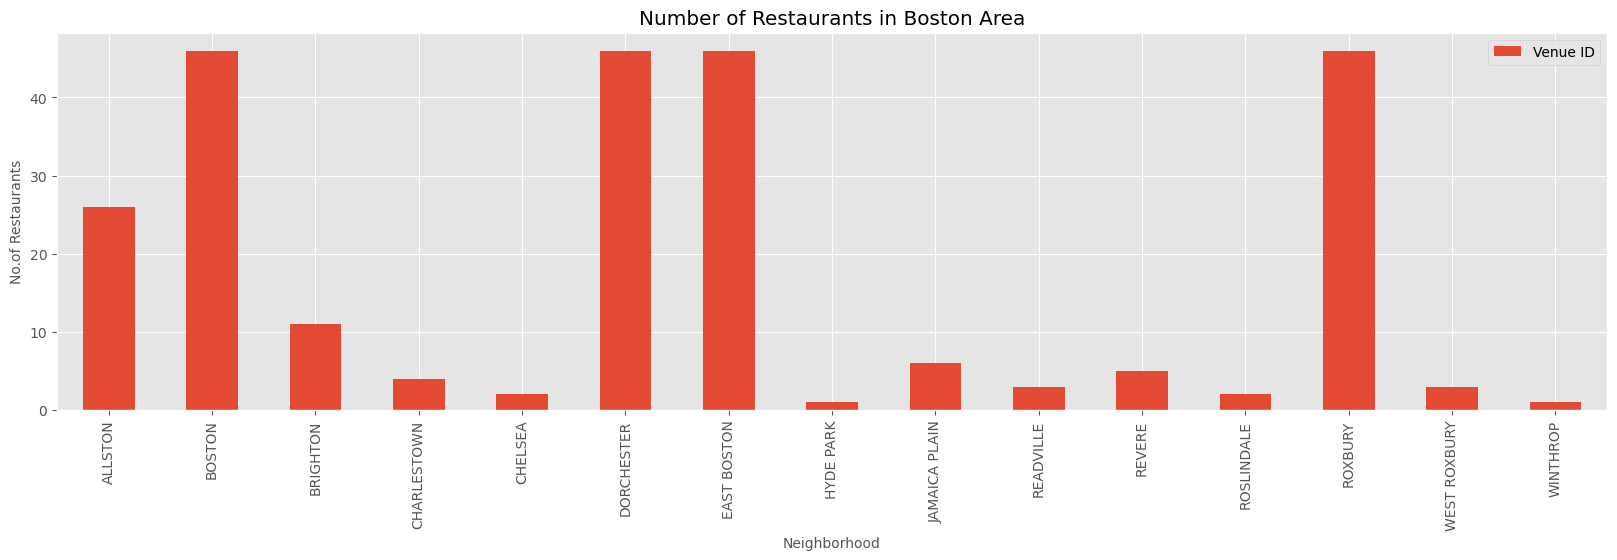

In [43]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(20,5), dpi = 100)
# title
plt.title('Number of Restaurants in Boston Area')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 10)
#On y-axis
plt.ylabel('No.of Restaurants', fontsize=10)
#giving a bar plot
boston_rest_2.groupby('Neighborhood')['Venue ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

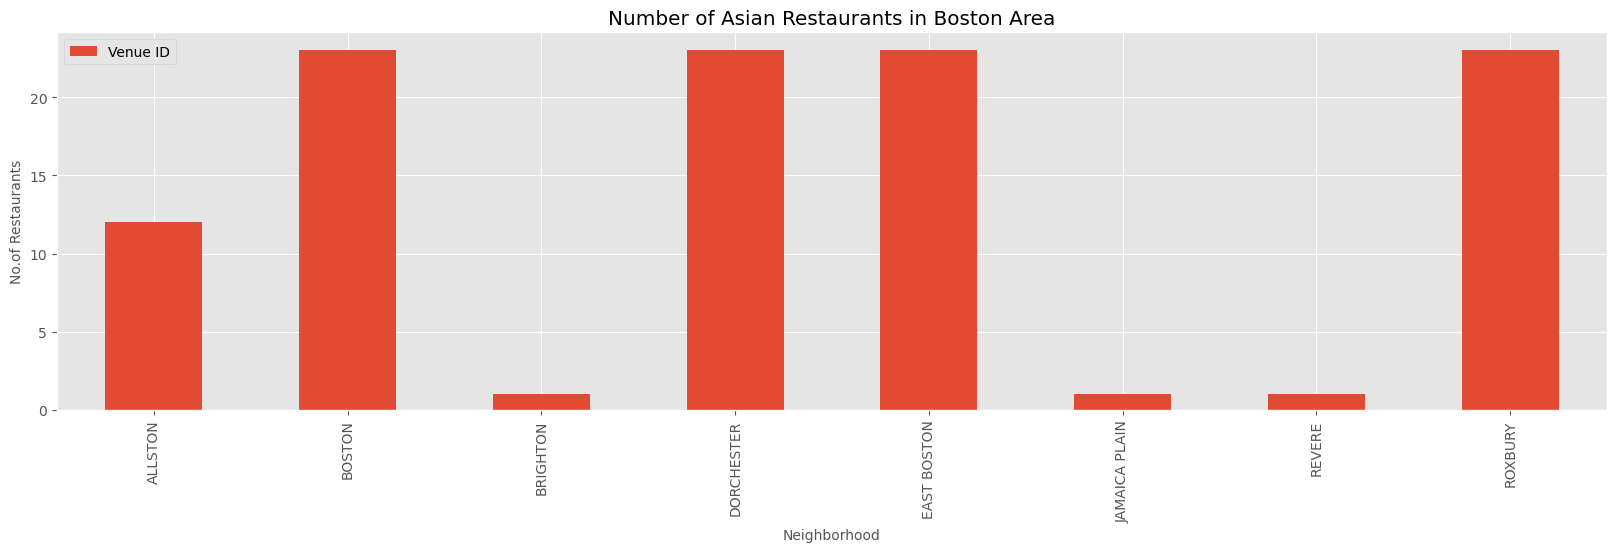

In [44]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(20,5), dpi = 100)
# title
plt.title('Number of Asian Restaurants in Boston Area')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 10)
#On y-axis
plt.ylabel('No.of Restaurants', fontsize=10)
#giving a bar plot
boston_asian_rest.groupby('Neighborhood')['Venue ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [45]:
#Calculate MA population

ma_population=geo_df[geo_df.state == 'MA']
ma_population=ma_population[['zip','primary_city','county','estimated_population']]
ma_population.rename(columns={'primary_city':'Neighborhood','county':'County'}, inplace=True)
ma_population["zip"] = ma_population["zip"].astype(int).astype(str)
ma_population.drop(['zip'], axis=1, inplace=True)
ma_population =ma_population.drop_duplicates()
ma_population.head()

,Neighborhood,County,estimated_population
194,Agawam,Hampden,14021
195,Amherst,Hampshire,16532
196,Amherst,Hampshire,0
197,Amherst,Hampshire,742
198,Barre,Worcester,3935


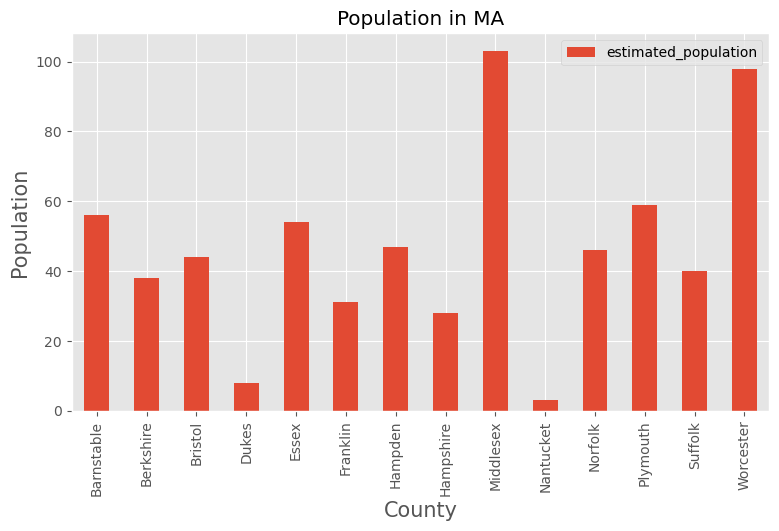

In [46]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Population in MA')
#On x-axis
plt.xlabel('County', fontsize = 15)
#On y-axis
plt.ylabel('Population', fontsize=15)
#giving a bar plot
ma_population.groupby('County')['estimated_population'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [53]:
boston_population = ma_population[ma_population['County'] == 'Suffolk'].reset_index(drop=True)
boston_population = boston_population.drop_duplicates()
boston_population['Neighborhood'] = boston_population['Neighborhood'].str.replace('Dorchester Center', 'Dorchester')
boston_population['Neighborhood'] = boston_population['Neighborhood'].str.replace('Roxbury Crossing', 'Roxbury')
boston_population.groupby(['Neighborhood']).count()

,County,estimated_population
Neighborhood,,
Allston,1,1
Boston,21,21
Brighton,1,1
Charlestown,1,1
Chelsea,1,1
Dorchester,4,4
East Boston,1,1
Hyde Park,1,1
Jamaica Plain,1,1


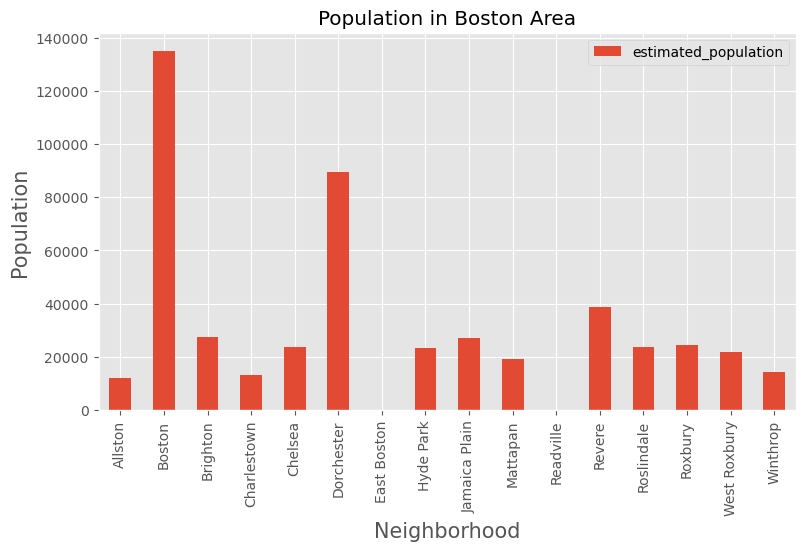

In [54]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Population in Boston Area')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Population', fontsize=15)
#giving a bar plot
boston_population.groupby('Neighborhood')['estimated_population'].sum().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [82]:
# one hot encoding
boston_asian_rest
boston_onehot = pd.get_dummies(boston_asian_rest[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
boston_onehot['Neighborhood'] = boston_asian_rest['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [boston_onehot.columns[-1]] + list(boston_onehot.columns[:-1])
boston_onehot = boston_onehot[fixed_columns]

boston_onehot.shape

(107, 15)

In [83]:
boston_grouped = boston_onehot.groupby('Neighborhood').mean().reset_index()
boston_grouped                         # 
boston_grouped.shape

num_top_venues = 10 
for hood in boston_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = boston_grouped[boston_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 3})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ALLSTON----
                   venue   freq
0      Korean Restaurant  0.250
1       Sushi Restaurant  0.167
2  Vietnamese Restaurant  0.167
3       Asian Restaurant  0.083
4    Dumpling Restaurant  0.083
5      Indian Restaurant  0.083
6    Japanese Restaurant  0.083
7        Thai Restaurant  0.083
8     Dim Sum Restaurant  0.000
9      Hotpot Restaurant  0.000


----BOSTON----
                           venue   freq
0               Asian Restaurant  0.304
1               Sushi Restaurant  0.174
2             Dim Sum Restaurant  0.087
3              Hotpot Restaurant  0.087
4                   Noodle House  0.087
5            Japanese Restaurant  0.043
6              Korean Restaurant  0.043
7               Malay Restaurant  0.043
8            Szechuan Restaurant  0.043
9  Vegetarian / Vegan Restaurant  0.043


----BRIGHTON----
                 venue  freq
0     Sushi Restaurant   1.0
1     Asian Restaurant   0.0
2   Dim Sum Restaurant   0.0
3  Dumpling Restaurant   0.0
4    Hotpot

In [95]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10     # normally only the top 10 

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = boston_grouped['Neighborhood']

for ind in np.arange(boston_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(boston_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(18)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALLSTON,Korean Restaurant,Vietnamese Restaurant,Sushi Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Dumpling Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Szechuan Restaurant
1,BOSTON,Asian Restaurant,Sushi Restaurant,Noodle House,Hotpot Restaurant,Dim Sum Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Szechuan Restaurant,Malay Restaurant,Korean Restaurant
2,BRIGHTON,Sushi Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Szechuan Restaurant,Noodle House,Malay Restaurant,Korean Restaurant,Japanese Restaurant,Indian Restaurant
3,DORCHESTER,Asian Restaurant,Sushi Restaurant,Noodle House,Hotpot Restaurant,Dim Sum Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Szechuan Restaurant,Malay Restaurant,Korean Restaurant
4,EAST BOSTON,Asian Restaurant,Sushi Restaurant,Noodle House,Hotpot Restaurant,Dim Sum Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Szechuan Restaurant,Malay Restaurant,Korean Restaurant
5,JAMAICA PLAIN,Indian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Noodle House,Malay Restaurant,Korean Restaurant,Japanese Restaurant
6,REVERE,Asian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Noodle House,Malay Restaurant,Korean Restaurant,Japanese Restaurant
7,ROXBURY,Asian Restaurant,Sushi Restaurant,Noodle House,Hotpot Restaurant,Dim Sum Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Szechuan Restaurant,Malay Restaurant,Korean Restaurant


In [96]:
#Run k-means to cluster Asian venues in the neighborhood into 18 clusters.
kclusters = 5           # set number of clusters

# new data frame for grouping by neighborhood
boston_grouped_clustering = boston_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(boston_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:18]



array([4, 0, 2, 0, 0, 1, 3, 0], dtype=int32)

In [97]:
#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

boston_merged = boston_asian_rest

In [98]:
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
boston_merged = boston_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

boston_merged.head(20) # check the last columns!

,Venue,Neighborhood,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Shabu Zen,ALLSTON,42.352678,-71.129113,Japanese Restaurant,4a89e36df964a520430920e3,4,Korean Restaurant,Vietnamese Restaurant,Sushi Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Dumpling Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Szechuan Restaurant
9,Oppa Sushi,ALLSTON,42.350910,-71.131357,Sushi Restaurant,534ef45f498e6d754cce70c2,4,Korean Restaurant,Vietnamese Restaurant,Sushi Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Dumpling Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Szechuan Restaurant
10,Dolphin Bay,ALLSTON,42.352553,-71.128739,Asian Restaurant,554aa34d498e49a9de10481f,4,Korean Restaurant,Vietnamese Restaurant,Sushi Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Dumpling Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Szechuan Restaurant
19,Seoul Soulongtang,ALLSTON,42.350246,-71.131866,Korean Restaurant,528ed6f311d2782026f3db76,4,Korean Restaurant,Vietnamese Restaurant,Sushi Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Dumpling Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Szechuan Restaurant
22,Dumpling Kingdom,ALLSTON,42.352077,-71.131895,Dumpling Restaurant,57845b4e498e0942ee8b3ce6,4,Korean Restaurant,Vietnamese Restaurant,Sushi Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Dumpling Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Szechuan Restaurant
23,Punjab Palace,ALLSTON,42.352839,-71.130520,Indian Restaurant,4a843981f964a520f5fb1fe3,4,Korean Restaurant,Vietnamese Restaurant,Sushi Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Dumpling Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Szechuan Restaurant
24,Fish Market Sushi Bar,ALLSTON,42.353039,-71.132975,Sushi Restaurant,4b758e61f964a520e7132ee3,4,Korean Restaurant,Vietnamese Restaurant,Sushi Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Dumpling Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Szechuan Restaurant
28,Coreanos,ALLSTON,42.353042,-71.132925,Korean Restaurant,575b6748498ee1cbfbeb92af,4,Korean Restaurant,Vietnamese Restaurant,Sushi Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Dumpling Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Szechuan Restaurant
30,Myung Dong 1st Ave,ALLSTON,42.353383,-71.132121,Korean Restaurant,4b22dcf4f964a520064f24e3,4,Korean Restaurant,Vietnamese Restaurant,Sushi Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Dumpling Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Szechuan Restaurant
37,Le's Vietnamese Restaurant,ALLSTON,42.353022,-71.131408,Vietnamese Restaurant,4b3d5e57f964a520329325e3,4,Korean Restaurant,Vietnamese Restaurant,Sushi Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Dumpling Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Szechuan Restaurant


In [61]:
address = 'Suffolk County, MA'

geolocator = Nominatim(user_agent="ma_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston Area are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Boston Area are 42.3544455, -70.9788771.


In [62]:
map_clusters = folium.Map(location=[42.3544455, -70.9788771], zoom_start=11)

for row in boston_data.iterrows():
    lat = row[1]['Latitude']
    lng = row[1]['Longitude']
    label = row[1]['Neighborhood']

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(boston_merged['Venue Latitude'], boston_merged['Venue Longitude'], boston_merged['Neighborhood'], boston_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [63]:
boston_rest_2.shape
boston_rest_2_distinct=boston_rest_2.drop_duplicates('Venue')
boston_rest_3=boston_rest_2_distinct.iloc[0:200,:]
boston_rest_3.head()

,Venue,Neighborhood,Venue Latitude,Venue Longitude,Venue Category,Venue ID
3,Shabu Zen,ALLSTON,42.352678,-71.129113,Japanese Restaurant,4a89e36df964a520430920e3
9,Oppa Sushi,ALLSTON,42.350910,-71.131357,Sushi Restaurant,534ef45f498e6d754cce70c2
10,Dolphin Bay,ALLSTON,42.352553,-71.128739,Asian Restaurant,554aa34d498e49a9de10481f
12,bb.q chicken,ALLSTON,42.351014,-71.131353,Fried Chicken Joint,58d5a4a713af1c20e21f6b81
13,Mala Restaurant,ALLSTON,42.352960,-71.131033,Chinese Restaurant,5599b403498e4220e1753509


In [64]:
searchfor = ['Bubble', 'Tea', 'Tea Room', 'Dessert Shop']
Bubble_tea=boston_venues.loc[boston_venues["Venue Category"].str.contains('|'.join(searchfor))]
Bubble_tea.shape

(32, 8)

In [65]:
Bubble_tea.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
ALLSTON,1,1,1,1,1,1,1
BOSTON,5,5,5,5,5,5,5
BRIGHTON,1,1,1,1,1,1,1
DORCHESTER,10,10,10,10,10,10,10
EAST BOSTON,5,5,5,5,5,5,5
ROXBURY,10,10,10,10,10,10,10


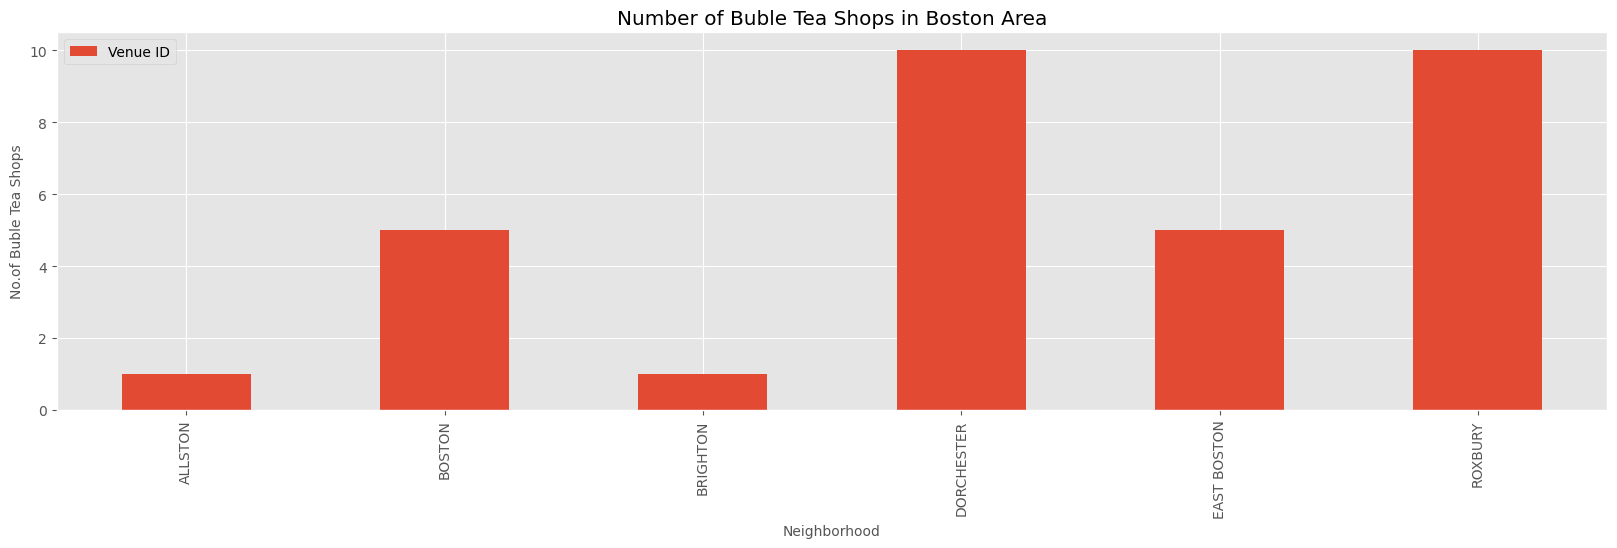

In [66]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(20,5), dpi = 100)
# title
plt.title('Number of Buble Tea Shops in Boston Area')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 10)
#On y-axis
plt.ylabel('No.of Buble Tea Shops', fontsize=10)
#giving a bar plot
Bubble_tea.groupby('Neighborhood')['Venue ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()